In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.linalg import ishermitian
from functools import partial
import warnings
np.set_printoptions(linewidth=np.inf, precision=2)
# Suppress warnings from root finding when a bound state doesn't exist
warnings.filterwarnings('ignore', 'b_less_than_a', UserWarning)

# --- global sizes -------------------------------------------------
N_SUB = 4                     # sites in a unit cell
DIM   = N_SUB**3              # 64 internal states

I4  = np.eye(N_SUB, dtype=complex)
I64 = np.eye(DIM,    dtype=complex)

def add_conj(mat):
    return mat + mat.conj().T

# --- 1. Single-Particle Properties (Vectorized) ---

def H0(k, phi):
    """single-particle momentum-space Hamiltonian H(k)."""
    k = np.atleast_1d(k)
    N = k.shape[0]

    H = np.zeros((k.shape[0], 4, 4), dtype=complex)
    for i in range(N):
        H_i = np.zeros((4, 4), dtype=complex)
        H_i[0, 1] = np.exp(-1j * phi/2) + np.exp(1j * (-k[i] + phi/2))
        H_i[0, 2] = 1 + np.exp(-1j * k[i])
        H_i[0, 3] = np.exp(1j * phi/2) + np.exp(-1j * (k[i] + phi/2))
        H[i] = add_conj(H_i)
    
    return H[0] if N == 1 else H

def get_single_particle_bands(k_values, phi):
    """Calculate the 4 single-particle energy bands."""
    energies = np.linalg.eigvalsh(H0(k_values, phi))
    return energies.T

def get_continuum_bounds(K, phi, num_q=101):
    """Calculate the two-particle scattering continuum bounds for a given K."""
    q_values = np.linspace(-np.pi, np.pi, num_q)
    p_values = np.linspace(-np.pi, np.pi, num_q)

    k1 = K/3 + q_values 
    k2 = K/3 - q_values + p_values
    k3 = K/3 - p_values

    eigs1 = np.linalg.eigvalsh(H0(k1, phi))
    eigs2 = np.linalg.eigvalsh(H0(k2, phi))
    eigs3 = np.linalg.eigvalsh(H0(k3, phi))

    continuum_energies = (
        eigs1[:, :, np.newaxis, np.newaxis]
        + eigs2[:, np.newaxis, :, np.newaxis]
        + eigs3[:, np.newaxis, np.newaxis, :]
    ).flatten()
    return np.min(continuum_energies), np.max(continuum_energies)

def get_real_space_matrices(phi):
    H_intra = add_conj(np.array([[0,np.exp(-1j*phi/2), 1 , np.exp(1j*phi/2)], [0,0,0,0],[0,0,0,0],[0,0,0,0]] ))
    H_inter_minus = np.array([[0,np.exp(1j*phi/2), 1 , np.exp(-1j*phi/2)], [0,0,0,0],[0,0,0,0],[0,0,0,0]] )
    H_inter = H_inter_minus.T.conj()
    return H_intra, H_inter, H_inter_minus
    
def get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus):
    """
    Constructs the effective 64x64 hopping matrices for the relative coordinate.
    This version is based on the definitive derivation using r and s.
    """
    T_dict = {}
    
    T_dict[0] = np.kron(np.kron(H_intra, I4),I4) + np.kron(np.kron(I4,H_intra),I4) + np.kron(np.kron(I4,I4),H_intra)

    T_dict[1] = np.kron(np.kron(H_inter, I4),I4)*np.exp(1j*K/3)
    T_dict[-1] =np.kron(np.kron(H_inter_minus, I4),I4)*np.exp(-1j*K/3)

    T_dict[2] = np.kron(np.kron(I4,H_inter),I4)*np.exp(1j*K/3)
    T_dict[-2] =np.kron(np.kron(I4,H_inter_minus),I4)*np.exp(-1j*K/3)

    T_dict[3] = np.kron(np.kron(I4,I4),H_inter)*np.exp(1j*K/3)
    T_dict[-3] =np.kron(np.kron(I4,I4),H_inter_minus)*np.exp(-1j*K/3)
    return T_dict

# --- 3. Green's Function and Root Finding for Multiple Bands ---

def calculate_G00(E, T_dict, num_q=201):
    """
    Vectorised on‑site free Green's function G_{00}^{(0)}(E).
    Returns a 64×64 complex matrix.
    """
    q_vals = np.linspace(-np.pi, np.pi, num_q, dtype=float)
    q1, q2 = np.meshgrid(q_vals, q_vals, indexing='ij')     # (Nq, Nq)

    # Build H_kin(K, q1, q2) on the whole grid (broadcasting)
    H = (
          T_dict[0]
        + T_dict[ 1]*np.exp( 1j*q1)          + T_dict[-1]*np.exp(-1j*q1)
        + T_dict[ 2]*np.exp( 1j*(-q1+q2))    + T_dict[-2]*np.exp(-1j*(-q1+q2))
        + T_dict[ 3]*np.exp(-1j*q2)          + T_dict[-3]*np.exp( 1j*q2)
    )                                         # shape (Nq,Nq,64,64)

    H = H.reshape(-1, DIM, DIM)               # (Nq²,64,64)
    G = np.linalg.inv(E*I64 - H)              # vectorised inversion
    G = G.reshape(num_q, num_q, DIM, DIM)

    return G.mean(axis=(0,1))                 # already divides by Nq²

def eigenvalue_root_equation(E, U, T, eigenvalue_index):
    """
    Solve λ_i(E) - 1/U = 0 for the four diagonal trimer channels.
    """
    G00 = calculate_G00(E, T)
    diag_indices = [a*N_SUB**2 + a*N_SUB + a  for a in range(N_SUB)]
    G_red = G00[np.ix_(diag_indices, diag_indices)]
    lam = np.sort(np.linalg.eigvalsh(G_red))[eigenvalue_index]
    return lam - 1.0/(3*U)



Calculating continuum...
Searching for bound state bands...
--- Searching for band #1 ---
--- Searching for band #2 ---
--- Searching for band #3 ---
--- Searching for band #4 ---
Plotting results. Found 0 bound state band(s).


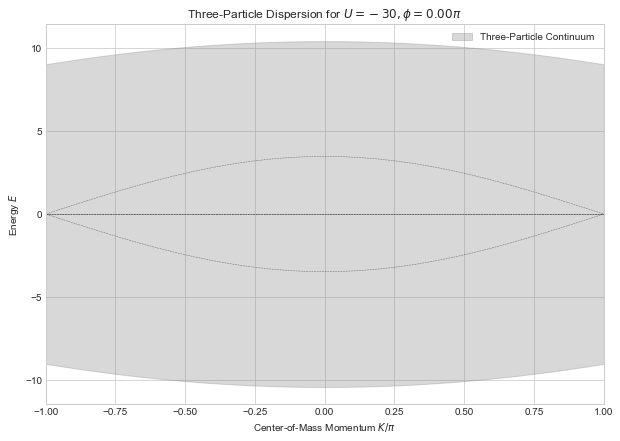

In [29]:

# --- Parameters ---
U = -30  # Interaction strength. Larger |U| often reveals more bands.
phi = 0# 2*np.pi/3
N_K = 31 # Number of COM momentum points

K_values = np.linspace(-np.pi, np.pi, N_K)

# We now need a place to store multiple bands
all_bound_state_bands = []
num_bands_to_find = 4

# --- Pre-calculate real-space matrices ---
H_intra, H_inter, H_inter_minus = get_real_space_matrices(phi)

print("Calculating continuum...")
continuum_min = np.zeros(N_K)
continuum_max = np.zeros(N_K)
for i, K in enumerate(K_values):
    continuum_min[i], continuum_max[i] = get_continuum_bounds(K, phi)

print("Searching for bound state bands...")
# Loop over each potential band
for band_idx in range(num_bands_to_find):
    print(f"--- Searching for band #{band_idx + 1} ---")
    current_band_energies = np.full(N_K, np.nan)
    
    # Loop over each K point
    for i, K in enumerate(K_values):
        # Get effective matrices for this K
        T = get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus)
        
        # Define search range. Widen it slightly to catch all bands.
        if U < 0:
            search_min = continuum_min[i] - (2*4) * abs(U)
            search_max = continuum_min[i] - 1e-6
        else:
            search_min = continuum_max[i] + 1e-6
            search_max = continuum_max[i] + (2*4) * abs(U)

        # ******************** FIX IS HERE ********************
        # Use the correct keyword argument 'T_minus_1'
        f_to_solve = partial(eigenvalue_root_equation, U=U, T=T,
                                eigenvalue_index=band_idx)
        # *****************************************************
        
        try:
            # The bracket might fail if the function doesn't cross zero.
            # We check the signs at the boundaries.
            val_min = f_to_solve(search_min)
            val_max = f_to_solve(search_max)
            if np.isfinite(val_min) and np.isfinite(val_max) and np.sign(val_min) != np.sign(val_max):
                sol = root_scalar(f_to_solve, bracket=[search_min, search_max], method='brentq')
                if sol.converged:
                    current_band_energies[i] = sol.root
        except (ValueError, RuntimeError):
                # This can happen if the root is not in the bracket or other issues.
                pass
    
    # Only add the band if we actually found any energies for it
    if not np.all(np.isnan(current_band_energies)):
        all_bound_state_bands.append(current_band_energies)

# --- Plotting ---
print(f"Plotting results. Found {len(all_bound_state_bands)} bound state band(s).")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the continuum
ax.fill_between(K_values / np.pi, continuum_min, continuum_max, 
                color='gray', alpha=0.3, label='Three-Particle Continuum')

# Plot the single-particle bands for reference
k_plot = np.linspace(-np.pi, np.pi, N_K)
sp_bands = get_single_particle_bands(k_plot, phi)
for band in sp_bands:
    ax.plot(k_plot / np.pi, band, 'k--', linewidth=0.5, alpha=0.5, label='_nolegend_')
    
# Plot all the found bound state bands
colors = ['blue', 'red', 'green']
for i, band_energies in enumerate(all_bound_state_bands):
    ax.plot(K_values / np.pi, band_energies, '-', color=colors[i % len(colors)],
            linewidth=2.5, label=f'Dimer Band #{i+1}')

ax.set_xlabel(r'Center-of-Mass Momentum $K/\pi$')
ax.set_ylabel('Energy $E$')
ax.set_title(fr'Three-Particle Dispersion for $U={U}, \phi={phi/np.pi:.2f}\pi$')
ax.legend()
ax.set_xlim(-1, 1)

#plt.savefig(f"{U}U0phibands.pdf")
plt.show()


In [27]:
def calculate_G00(E, T_dict, num_q=121):
    """
    Vectorised on‑site free Green function G_{00}^{(0)}(E) for the three‑boson
    problem.  Returns a 64 × 64 complex matrix.
    """
    q_vals = np.linspace(-np.pi, np.pi, num_q, dtype=float)
    q1, q2 = np.meshgrid(q_vals, q_vals, indexing='ij')        # (Nq,Nq)

    # phases with trailing singleton axes
    e_pq1  = np.exp(+1j*q1)[..., None, None]
    e_mq1  = np.exp(-1j*q1)[..., None, None]
    e_pqm  = np.exp(+1j*(-q1+q2))[..., None, None]
    e_mqm  = np.exp(-1j*(-q1+q2))[..., None, None]
    e_mq2  = np.exp(-1j*q2)[..., None, None]
    e_pq2  = np.exp(+1j*q2)[..., None, None]

    # hopping matrices with leading singleton axes
    T0  = T_dict[ 0][None, None]
    T1  = T_dict[ 1][None, None]
    Tm1 = T_dict[-1][None, None]
    T2  = T_dict[ 2][None, None]
    Tm2 = T_dict[-2][None, None]
    T3  = T_dict[ 3][None, None]
    Tm3 = T_dict[-3][None, None]

    H = (
          T0
        + T1  * e_pq1    + Tm1 * e_mq1
        + T2  * e_pqm    + Tm2 * e_mqm
        + T3  * e_mq2    + Tm3 * e_pq2
    )                                               # (Nq,Nq,64,64)

    H = H.reshape(-1, DIM, DIM)                    # (Nq²,64,64)
    G = np.linalg.inv(E*I64 - H)                   # batch inversion
    G = G.reshape(num_q, num_q, DIM, DIM)

    return G.mean(axis=(0, 1))                     # average over q₁,q₂



# --- quick probe for ONE K  ------------------------------
K  = 0.0                                   # pick any K
T  = get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus)

E_grid = np.linspace(continuum_min[K==K_values][0]-80,
                     continuum_min[K==K_values][0]-1e-3, 400)

lam   = []
for E in E_grid:
    G   = calculate_G00(E, T, num_q=121)
    G4  = G[np.ix_([0,21,42,63],[0,21,42,63])]
    lam.append(np.sort(np.linalg.eigvalsh(G4))[0])   # lowest eigen‑value

lam = np.array(lam)
print('min λ  =', lam.min())
print('1/(3U) =', 1.0/(3*U))


ValueError: operands could not be broadcast together with shapes (1,1,64,64) (121,121) 